In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import torch
import torch.nn as nn

In [3]:
def moment_fn(x, test_fn):
    if torch.is_tensor(x):
        with torch.no_grad():
            t1 = torch.cat([torch.ones((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
            t0 = torch.cat([torch.zeros((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
    else:
        t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
        t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.linear_model import LassoCV

def get_reg_fn(X, y):
    est = LassoCV(max_iter=10000, random_state=123).fit(X, y)
    return lambda: Lasso(alpha=est.alpha_, max_iter=10000, random_state=123)

In [6]:
from debiased import DebiasedMoment
from advreisz.linear import SparseLinearAdvRiesz

def get_splin_fn(X):
    return lambda: SparseLinearAdvRiesz(moment_fn,
                                        featurizer=Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False)),
                                                             ('s', StandardScaler()),
                                                             ('cnt', PolynomialFeatures(degree=1, include_bias=True))]),
                                        n_iter=50000, lambda_theta=0.01, B=10,
                                        tol=0.00001)

In [7]:
from advreisz.kernel import AdvNystromKernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# advkernel_fn = lambda: AdvKernelReisz(kernel=AutoKernel(type='var'), regm=6e-4, regl=1e-4)

def get_advnyskernel_fn(X):
    est = AdvNystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                regm='auto', regl='auto', n_components=100, random_state=123)
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: AdvNystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                         regm=6*reg, regl=reg, n_components=100, random_state=123)

In [8]:
from advreisz.kernel import AdvKernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# advkernel_fn = lambda: AdvKernelReisz(kernel=AutoKernel(type='var'), regm=6e-4, regl=1e-4)

def get_advkernel_fn(X):
    est = AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm='auto', regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm=6*reg, regl=reg)

In [9]:
from advreisz.kernel import NystromKernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# kernel_fn = lambda: KernelReisz(kernel=AutoKernel(type='var'), regl=6e-2)

def get_nyskernel_fn(X):
    est = NystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                             regl='auto', n_components=100, random_state=123)
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: NystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                      regl=reg, n_components=100, random_state=123)

In [10]:
from advreisz.kernel import KernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# kernel_fn = lambda: KernelReisz(kernel=AutoKernel(type='var'), regl=6e-2)

def get_kernel_fn(X):
    est = KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl=reg)

In [11]:
from utilities import PluginRR

def get_lg_plugin_fn(X):
    clf = LogisticRegressionCV(cv=3, max_iter=10000, random_state=123)
    C_ = clf.fit(X[:, 1:], X[:, 0]).C_[0]
    return lambda: PluginRR(model_t=LogisticRegression(C=C_, max_iter=10000, random_state=123),
                            min_propensity=0)


def get_rf_plugin_fn(X):
    gcv = GridSearchCV(RandomForestClassifier(bootstrap=True, random_state=123),
                       param_grid={'max_depth': [3, None],
                                   'min_samples_leaf': [10, 50]},
                       scoring='r2',
                       cv=5)
    best_model = clone(gcv.fit(X[:, 1:], X[:, 0]).best_estimator_)
    return lambda: PluginRR(model_t=best_model, min_propensity=0)

In [23]:
from utilities import FitParamsWrapper
from advreisz.deepreisz import AdvReisz


device = None #torch.cuda.current_device() if torch.cuda.is_available() else None

# Returns a deep model for the reisz representer
def get_learner(n_t, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

# Returns a deep model for the test functions
def get_adversary(n_z, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

print("GPU:", torch.cuda.is_available())

def get_agmm_fn(X):
    return lambda: FitParamsWrapper(AdvReisz(get_learner(10, 100, 0.),
                                             get_adversary(10, 100, 0.),
                                             moment_fn),
                                   val_fr=.2,
                                   preprocess_epochs=200,
                                   earlystop_rounds=100,
                                   store_test_every=20,
                                   learner_lr=1e-4, adversary_lr=1e-4,
                                   learner_l2=6e-4, adversary_l2=1e-4,
                                   n_epochs=1000, bs=100,
                                   logger=None, model_dir=str(Path.home()), device=device, verbose=1)

GPU: True


In [24]:
import pandas as pd

n_splits = 1
res = {}
for q in np.arange(0, 6):
    res[f'q={q}'] = {}
    print(f'Quintile={q}')
    df = pd.read_csv(f'401k/quintile{q}_trimmed.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
    
    # scale data
    y = y.astype(np.double)
    X = X.astype(np.double)
    X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
    y_scale = np.std(y)
    y = y / y_scale
    
    # shuffle data
    inds = np.arange(X.shape[0])
    np.random.seed(123)
    np.random.shuffle(inds)
    X, y = X[inds].copy(), y[inds].copy()

    # filter extrement propensities
    clf = LogisticRegressionCV(cv=5, max_iter=10000, random_state=123).fit(X[:, 1:], X[:, 0])
    prop = clf.predict_proba(X[:, 1:])
    filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
    print(X.shape[0], np.sum(filt))
    X, y = X[filt], y[filt]

    for name, get_reisz_fn in [
#                                ('splin', get_splin_fn),
#                                ('advrkhs', get_advkernel_fn),
#                                ('rkhs', get_kernel_fn),
                               ('nys_advrkhs', get_advnyskernel_fn),
                               ('nys_rkhs', get_nyskernel_fn),
                               ('plugin_lg', get_lg_plugin_fn),
                               ('plugin_rf', get_rf_plugin_fn),
                               ('advnnet', get_agmm_fn)
                                ]:
        est = DebiasedMoment(moment_fn=moment_fn,
                             get_reisz_fn=get_reisz_fn,
                             get_reg_fn=get_reg_fn, n_splits=n_splits)
        est.fit(X, y)
        p, s, l, u = est.avg_moment()
        res[f'q={q}'][name] = {'point': p * y_scale, 'stderr': s * y_scale,
                               'lower': l * y_scale, 'upper': u * y_scale}
        p, s, l, u = est.avg_moment(tmle=True)
        res[f'q={q}'][f'{name}_tmle'] = {'point': p * y_scale, 'stderr': s * y_scale,
                                         'lower': l * y_scale, 'upper': u * y_scale}

    print(res[f'q={q}'])
    res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
res = pd.concat(res)

Quintile=0
9848 9804
[0.016039652568307746, 0.01603752951706585, 0.016019790514524426, 0.015874347581134565, 0.014862044787439618, 0.01515444221904554, 0.08337171369807772, 0.34134784684399166, 0.801666637469625, 1.8984371136683524, 2.7626659733521626, 2.872410828740729, 2.875816992744949, 2.8758729251874837]
4.923882631706742e-07
[-5.448686435053953, -5.448711076451658, -5.448909482304859, -5.450425376847983, -5.457912473915507, -5.430576791785836, -5.176330665257372, -4.54588568504963, -3.1967807760770075, -0.9291257555408953, -0.13659551160611666, -0.01724662414160401]
4.328761281083062e-05
Splitting
Epoch #0
Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39

Validation moment violation: 0.1151067
Epoch #111
Validation moment violation: 0.112986155
Epoch #112
Validation moment violation: 0.119059384
Epoch #113
Validation moment violation: 0.052228156
Epoch #114
Validation moment violation: 0.1064375
Epoch #115
Validation moment violation: 0.048293404
Epoch #116
Validation moment violation: 0.053847738
Epoch #117
Validation moment violation: 0.07215301
Epoch #118
Validation moment violation: 0.08011481
Epoch #119
Validation moment violation: 0.057483546
Epoch #120
Validation moment violation: 0.109892145
Epoch #121
Validation moment violation: 0.09217743
Epoch #122
Validation moment violation: 0.047116928
Epoch #123
Validation moment violation: 0.050942056
Epoch #124
Validation moment violation: 0.07187727
Epoch #125
Validation moment violation: 0.15239231
Epoch #126
Validation moment violation: 0.09157463
Epoch #127
Validation moment violation: 0.11082352
Epoch #128
Validation moment violation: 0.0475959
Epoch #129
Validation moment violati

Validation moment violation: 2.5015278
Epoch #29
Validation moment violation: 2.4719603
Epoch #30
Validation moment violation: 2.4384196
Epoch #31
Validation moment violation: 2.402202
Epoch #32
Validation moment violation: 2.3651917
Epoch #33
Validation moment violation: 2.3301938
Epoch #34
Validation moment violation: 2.2896864
Epoch #35
Validation moment violation: 2.2508008
Epoch #36
Validation moment violation: 2.2069736
Epoch #37
Validation moment violation: 2.1649888
Epoch #38
Validation moment violation: 2.1198273
Epoch #39
Validation moment violation: 2.0695674
Epoch #40
Validation moment violation: 2.0181959
Epoch #41
Validation moment violation: 1.9670825
Epoch #42
Validation moment violation: 1.9140015
Epoch #43
Validation moment violation: 1.8588002
Epoch #44
Validation moment violation: 1.802303
Epoch #45
Validation moment violation: 1.7473431
Epoch #46
Validation moment violation: 1.6862153
Epoch #47
Validation moment violation: 1.6279014
Epoch #48
Validation moment viol

Validation moment violation: 0.49596456
Epoch #194
Validation moment violation: 0.48714396
Epoch #195
Validation moment violation: 0.48519656
Epoch #196
Validation moment violation: 0.4787823
Epoch #197
Validation moment violation: 0.4678162
Epoch #198
Validation moment violation: 0.4634632
Epoch #199
Validation moment violation: 0.4522937
Epoch #200
Validation moment violation: 0.4436569
Epoch #201
Validation moment violation: 0.4455272
Epoch #202
Validation moment violation: 0.43940952
Epoch #203
Validation moment violation: 0.43349275
Epoch #204
Validation moment violation: 0.42335483
Epoch #205
Validation moment violation: 0.42032117
Epoch #206
Validation moment violation: 0.41121972
Epoch #207
Validation moment violation: 0.4046257
Epoch #208
Validation moment violation: 0.3992188
Epoch #209
Validation moment violation: 0.39056203
Epoch #210
Validation moment violation: 0.38881588
Epoch #211
Validation moment violation: 0.38529468
Epoch #212
Validation moment violation: 0.39007625

Validation moment violation: 0.26941514
Epoch #357
Validation moment violation: 0.27068028
Epoch #358
Validation moment violation: 0.27578822
Epoch #359
Validation moment violation: 0.27958423
Epoch #360
Validation moment violation: 0.27326223
Epoch #361
Validation moment violation: 0.26924306
Epoch #362
Validation moment violation: 0.27489966
Epoch #363
Validation moment violation: 0.27241626
Epoch #364
Validation moment violation: 0.26550618
Epoch #365
Validation moment violation: 0.2729915
Epoch #366
Validation moment violation: 0.25904563
Epoch #367
Validation moment violation: 0.2600996
Epoch #368
Validation moment violation: 0.26054662
Epoch #369
Validation moment violation: 0.25541043
Epoch #370
Validation moment violation: 0.25919035
Epoch #371
Validation moment violation: 0.26019534
Epoch #372
Validation moment violation: 0.25958312
Epoch #373
Validation moment violation: 0.25876898
Epoch #374
Validation moment violation: 0.26595387
Epoch #375
Validation moment violation: 0.26

Validation moment violation: 1.2741269
Epoch #62
Validation moment violation: 1.3807485
Epoch #63
Validation moment violation: 1.477929
Epoch #64
Validation moment violation: 1.5743368
Epoch #65
Validation moment violation: 1.6569874
Epoch #66
Validation moment violation: 1.736609
Epoch #67
Validation moment violation: 1.8064556
Epoch #68
Validation moment violation: 1.8623109
Epoch #69
Validation moment violation: 1.8894943
Epoch #70
Validation moment violation: 1.9043376
Epoch #71
Validation moment violation: 1.9134378
Epoch #72
Validation moment violation: 1.8934394
Epoch #73
Validation moment violation: 1.8448889
Epoch #74
Validation moment violation: 1.7707578
Epoch #75
Validation moment violation: 1.6956322
Epoch #76
Validation moment violation: 1.6363913
Epoch #77
Validation moment violation: 1.5384578
Epoch #78
Validation moment violation: 1.4437516
Epoch #79
Validation moment violation: 1.3685901
Epoch #80
Validation moment violation: 1.2535362
Epoch #81
Validation moment viol

Validation moment violation: 0.10484223
Epoch #224
Validation moment violation: 0.05940051
Epoch #225
Validation moment violation: 0.08109517
Epoch #226
Validation moment violation: 0.07348956
Epoch #227
Validation moment violation: 0.082914844
Epoch #228
Validation moment violation: 0.0741898
Epoch #229
Validation moment violation: 0.068334796
Epoch #230
Validation moment violation: 0.084321
Epoch #231
Validation moment violation: 0.06705047
Epoch #232
Validation moment violation: 0.061074596
Epoch #233
Validation moment violation: 0.07153571
Epoch #234
Validation moment violation: 0.0586929
Epoch #235
Validation moment violation: 0.06574101
Epoch #236
Validation moment violation: 0.050441276
Epoch #237
Validation moment violation: 0.0570355
Epoch #238
Validation moment violation: 0.04614043
Epoch #239
Validation moment violation: 0.048306648
Epoch #240
Validation moment violation: 0.045019284
Epoch #241
Validation moment violation: 0.04490332
Epoch #242
Validation moment violation: 0

Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39
Epoch #40
Epoch #41
Epoch #42
Epoch #43
Epoch #44
Epoch #45
Epoch #46
Epoch #47
Epoch #48
Epoch #49
Epoch #50
Epoch #51
Epoch #52
Epoch #53
Epoch #54
Epoch #55
Epoch #56
Epoch #57
Epoch #58
Epoch #59
Epoch #60
Epoch #61
Epoch #62
Epoch #63
Epoch #64
Epoch #65
Epoch #66
Epoch #67
Epoch #68
Epoch #69
Epoch #70
Epoch #71
Epoch #72
Epoch #73
Epoch #74
Epoch #75
Epoch #76
Epoch #77
Epoch #78
Epoch #79
Epoch #80
Epoch #81
Epoch #82
Epoch #83
Epoch #84
Epoch #85
Epoch #86
Epoch #87
Epoch #88
Epoch #89
Epoch #90
Epoch #91
Epoch #92
Epoch #93
Epoch #94
Epoch #95
Epoch #96
Epoch #97
Epoch #98
Epoch #99
Epoch #100
Epoch #101
Epoch #102
Epoch #103
Epoch #104
Epoch #105
Epoch #106
Epoch #107
Epoch #108
E

Validation moment violation: 0.11814952
Epoch #128
Validation moment violation: 0.1716176
Epoch #129
Validation moment violation: 0.21559587
Epoch #130
Validation moment violation: 0.24702768
Epoch #131
Validation moment violation: 0.2645274
Epoch #132
Validation moment violation: 0.27099085
Epoch #133
Validation moment violation: 0.26968023
Epoch #134
Validation moment violation: 0.24565148
Epoch #135
Validation moment violation: 0.2252979
Epoch #136
Validation moment violation: 0.17982385
Epoch #137
Validation moment violation: 0.14150313
Epoch #138
Validation moment violation: 0.090244934
Epoch #139
Validation moment violation: 0.056995705
Epoch #140
Validation moment violation: 0.023556193
Epoch #141
Validation moment violation: 0.042235937
Epoch #142
Validation moment violation: 0.07989906
Epoch #143
Validation moment violation: 0.1264106
Epoch #144
Validation moment violation: 0.16459787
Epoch #145
Validation moment violation: 0.21203667
Epoch #146
Validation moment violation: 0.

1969 1969
[0.09084029685848363, 0.09082685985834324, 0.09071441669432873, 0.0897805429971171, 0.08248205340327588, 0.04415995409016846, 0.0022749673038280857, 0.1034206149515973, 0.39092579831670615, 1.489861319248782, 2.428782952280806, 2.546373497114171, 2.54989101034546, 2.5499479928269615]
3.455107294592218e-05
[-3.9247567413599245, -3.9248782009787706, -3.925859543170567, -3.93357466754951, -3.9836036050821084, -4.124953708562612, -4.163156391027994, -3.956594734351576, -3.0459150236118204, -0.9074207413657687, -0.13296251470619805, -0.016774199384587237]
0.002848035868435799
Splitting
Epoch #0
Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39
Epoch #40
Ep

Validation moment violation: 0.22580372
Epoch #112
Validation moment violation: 0.2285832
Epoch #113
Validation moment violation: 0.21007104
Epoch #114
Validation moment violation: 0.17432974
Epoch #115
Validation moment violation: 0.12216394
Epoch #116
Validation moment violation: 0.069047585
Epoch #117
Validation moment violation: 0.02905528
Epoch #118
Validation moment violation: 0.0432347
Epoch #119
Validation moment violation: 0.0974637
Epoch #120
Validation moment violation: 0.15447056
Epoch #121
Validation moment violation: 0.19424716
Epoch #122
Validation moment violation: 0.2372027
Epoch #123
Validation moment violation: 0.2523669
Epoch #124
Validation moment violation: 0.25776854
Epoch #125
Validation moment violation: 0.26377612
Epoch #126
Validation moment violation: 0.23999144
Epoch #127
Validation moment violation: 0.21154635
Epoch #128
Validation moment violation: 0.19264135
Epoch #129
Validation moment violation: 0.1492399
Epoch #130
Validation moment violation: 0.12189

Epoch #76
Epoch #77
Epoch #78
Epoch #79
Epoch #80
Epoch #81
Epoch #82
Epoch #83
Epoch #84
Epoch #85
Epoch #86
Epoch #87
Epoch #88
Epoch #89
Epoch #90
Epoch #91
Epoch #92
Epoch #93
Epoch #94
Epoch #95
Epoch #96
Epoch #97
Epoch #98
Epoch #99
Epoch #100
Epoch #101
Epoch #102
Epoch #103
Epoch #104
Epoch #105
Epoch #106
Epoch #107
Epoch #108
Epoch #109
Epoch #110
Epoch #111
Epoch #112
Epoch #113
Epoch #114
Epoch #115
Epoch #116
Epoch #117
Epoch #118
Epoch #119
Epoch #120
Epoch #121
Epoch #122
Epoch #123
Epoch #124
Epoch #125
Epoch #126
Epoch #127
Epoch #128
Epoch #129
Epoch #130
Epoch #131
Epoch #132
Epoch #133
Epoch #134
Epoch #135
Epoch #136
Epoch #137
Epoch #138
Epoch #139
Epoch #140
Epoch #141
Epoch #142
Epoch #143
Epoch #144
Epoch #145
Epoch #146
Epoch #147
Epoch #148
Epoch #149
Epoch #150
Epoch #151
Epoch #152
Epoch #153
Epoch #154
Epoch #155
Epoch #156
Epoch #157
Epoch #158
Epoch #159
Epoch #160
Epoch #161
Epoch #162
Epoch #163
Epoch #164
Epoch #165
Epoch #166
Epoch #167
Epoch #168
E

Validation moment violation: 0.082241856
Epoch #140
Validation moment violation: 0.09825492
Epoch #141
Validation moment violation: 0.10342628
Epoch #142
Validation moment violation: 0.10803019
Epoch #143
Validation moment violation: 0.10289376
Epoch #144
Validation moment violation: 0.09166794
Epoch #145
Validation moment violation: 0.07593418
Epoch #146
Validation moment violation: 0.053913757
Epoch #147
Validation moment violation: 0.022193406
Epoch #148
Validation moment violation: 0.017908426
Epoch #149
Validation moment violation: 0.022006983
Epoch #150
Validation moment violation: 0.038901325
Epoch #151
Validation moment violation: 0.051835533
Epoch #152
Validation moment violation: 0.06892056
Epoch #153
Validation moment violation: 0.07090453
Epoch #154
Validation moment violation: 0.06373952
Epoch #155
Validation moment violation: 0.061235253
Epoch #156
Validation moment violation: 0.054702222
Epoch #157
Validation moment violation: 0.037284046
Epoch #158
Validation moment vio

Validation moment violation: 0.033554353
Epoch #299
Validation moment violation: 0.035134174
Epoch #300
Validation moment violation: 0.03538399
Epoch #301
Validation moment violation: 0.03181917
Epoch #302
Validation moment violation: 0.03515161
Epoch #303
Validation moment violation: 0.037936773
Epoch #304
Validation moment violation: 0.032411847
Epoch #305
Validation moment violation: 0.028152214
Epoch #306
Validation moment violation: 0.028348342
Epoch #307
Validation moment violation: 0.027842171
Epoch #308
Validation moment violation: 0.021673152
Epoch #309
Validation moment violation: 0.031382404
Epoch #310
Validation moment violation: 0.023818986
Epoch #311
Validation moment violation: 0.01967073
Epoch #312
Validation moment violation: 0.015141422
Epoch #313
Validation moment violation: 0.028019996
Epoch #314
Validation moment violation: 0.017737184
Epoch #315
Validation moment violation: 0.025568793
Epoch #316
Validation moment violation: 0.020339012
Epoch #317
Validation momen

In [33]:
res_f = old_res.reset_index()
res_d = {}
for q in range(6):
    res_d[f'q={q}' if q>0 else 'all'] = {method: "{:.2f} ({:.2f})".format(old_res.loc[(f'q={q}', method), 'point'],
                                                        old_res.loc[(f'q={q}', method), 'stderr'])
                                         for method in np.unique(res_f['level_1'].values)}        
res_d = pd.DataFrame(res_d)
res_d

,all,q=1,q=2,q=3,q=4,q=5
advrkhs,7780.32 (1148.31),3581.66 (886.33),1394.94 (1525.58),4855.22 (1609.45),10348.87 (2082.64),18917.36 (4666.67)
advrkhs_tmle,7812.02 (1148.36),3588.73 (886.50),1442.82 (1525.74),4874.83 (1609.54),10407.10 (2081.33),18958.28 (4666.20)
plugin_lg,6185.66 (1354.52),3763.84 (994.24),1055.13 (1660.50),4895.08 (1302.90),9287.63 (2327.20),17878.75 (4676.24)
plugin_lg_tmle,6160.61 (1354.20),3765.91 (994.18),1082.92 (1660.57),4896.83 (1302.85),9290.84 (2327.17),17887.27 (4676.08)
plugin_rf,7479.35 (1080.60),3729.77 (817.87),1211.21 (1507.66),4788.29 (1242.76),9652.92 (2239.55),18433.62 (4625.21)
plugin_rf_tmle,7598.20 (1080.47),3790.56 (818.19),1306.01 (1507.91),4803.93 (1242.77),9711.37 (2239.21),18514.11 (4624.93)
rkhs,7666.88 (1094.32),3459.64 (833.86),1099.58 (1569.98),5435.90 (1155.22),9997.07 (2049.76),18901.46 (4386.96)
rkhs_tmle,7702.31 (1094.42),3449.67 (833.67),1153.98 (1570.44),5482.76 (1155.03),10069.74 (2049.13),18969.25 (4386.63)
splin,7797.38 (1040.23),3765.62 (907.54),1328.90 (1570.15),5279.02 (1337.97),11190.33 (2187.54),20031.69 (4836.11)
splin_tmle,7807.19 (1040.47),3774.54 (908.39),1345.24 (1570.31),5293.18 (1337.79),11226.23 (2185.11),20053.82 (4834.65)


In [34]:
old_res_d = res_d

In [39]:
res_d = pd.concat([old_res_d.drop(['plugin_lg', 'plugin_lg_tmle', 'plugin_rf', 'plugin_rf_tmle']), res_d], axis=0)
res_d

,all,q=1,q=2,q=3,q=4,q=5
advrkhs,7780.32 (1148.31),3581.66 (886.33),1394.94 (1525.58),4855.22 (1609.45),10348.87 (2082.64),18917.36 (4666.67)
advrkhs_tmle,7812.02 (1148.36),3588.73 (886.50),1442.82 (1525.74),4874.83 (1609.54),10407.10 (2081.33),18958.28 (4666.20)
rkhs,7666.88 (1094.32),3459.64 (833.86),1099.58 (1569.98),5435.90 (1155.22),9997.07 (2049.76),18901.46 (4386.96)
rkhs_tmle,7702.31 (1094.42),3449.67 (833.67),1153.98 (1570.44),5482.76 (1155.03),10069.74 (2049.13),18969.25 (4386.63)
splin,7797.38 (1040.23),3765.62 (907.54),1328.90 (1570.15),5279.02 (1337.97),11190.33 (2187.54),20031.69 (4836.11)
splin_tmle,7807.19 (1040.47),3774.54 (908.39),1345.24 (1570.31),5293.18 (1337.79),11226.23 (2185.11),20053.82 (4834.65)
advnnet,8057.74 (1145.68),3715.19 (1004.38),1451.91 (1554.57),4893.89 (1630.69),10834.89 (1981.76),20003.73 (5007.86)
advnnet_tmle,8050.98 (1146.14),3725.72 (1004.53),1473.97 (1555.17),4894.32 (1630.75),10906.54 (1979.83),19984.01 (5005.83)
nys_advrkhs,7642.74 (1123.25),3297.10 (842.13),1112.28 (1705.50),5709.84 (990.64),10170.44 (2129.04),18909.06 (4397.46)
nys_advrkhs_tmle,7644.32 (1123.54),3280.17 (841.07),1140.30 (1705.94),5787.61 (990.55),10207.95 (2128.31),18943.21 (4396.91)


In [ ]:
import joblib

joblib.dump(res_d, f'401k_res_n_splits_{n_splits}.jbl')

In [ ]:
import joblib

old_res = joblib.load(f'401k_res_n_splits_{n_splits}.jbl')

In [35]:
res_f = res.reset_index()
res_d = {}
for q in range(6):
    res_d[f'q={q}' if q>0 else 'all'] = {method: "{:.2f} ({:.2f})".format(res.loc[(f'q={q}', method), 'point'],
                                                        res.loc[(f'q={q}', method), 'stderr'])
                                         for method in np.unique(res_f['level_1'].values)}        
res_d = pd.DataFrame(res_d)
res_d

,all,q=1,q=2,q=3,q=4,q=5
advnnet,8057.74 (1145.68),3715.19 (1004.38),1451.91 (1554.57),4893.89 (1630.69),10834.89 (1981.76),20003.73 (5007.86)
advnnet_tmle,8050.98 (1146.14),3725.72 (1004.53),1473.97 (1555.17),4894.32 (1630.75),10906.54 (1979.83),19984.01 (5005.83)
nys_advrkhs,7642.74 (1123.25),3297.10 (842.13),1112.28 (1705.50),5709.84 (990.64),10170.44 (2129.04),18909.06 (4397.46)
nys_advrkhs_tmle,7644.32 (1123.54),3280.17 (841.07),1140.30 (1705.94),5787.61 (990.55),10207.95 (2128.31),18943.21 (4396.91)
nys_rkhs,7668.70 (1120.26),3347.22 (869.65),1268.94 (1708.50),5713.12 (1044.87),9876.58 (2066.54),18766.86 (4458.29)
nys_rkhs_tmle,7674.06 (1120.54),3339.12 (868.89),1291.54 (1708.69),5762.74 (1044.77),9934.91 (2066.16),18786.90 (4457.75)
plugin_lg,6185.66 (1354.52),3763.84 (994.24),1055.13 (1660.50),4895.08 (1302.90),9287.63 (2327.20),17878.75 (4676.24)
plugin_lg_tmle,6160.61 (1354.20),3765.91 (994.18),1082.92 (1660.57),4896.83 (1302.85),9290.84 (2327.17),17887.27 (4676.08)
plugin_rf,7479.35 (1080.60),3729.77 (817.87),1211.21 (1507.66),4788.29 (1242.76),9652.92 (2239.55),18433.62 (4625.21)
plugin_rf_tmle,7598.20 (1080.47),3790.56 (818.19),1306.01 (1507.91),4803.93 (1242.77),9711.37 (2239.21),18514.11 (4624.93)


In [40]:
print(res_d.to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{lllllll}
\toprule
{} &                all &                q=1 &                q=2 &                q=3 &                 q=4 &                 q=5 \\
\midrule
advrkhs          &  7780.32 (1148.31) &   3581.66 (886.33) &  1394.94 (1525.58) &  4855.22 (1609.45) &  10348.87 (2082.64) &  18917.36 (4666.67) \\
advrkhs\_tmle     &  7812.02 (1148.36) &   3588.73 (886.50) &  1442.82 (1525.74) &  4874.83 (1609.54) &  10407.10 (2081.33) &  18958.28 (4666.20) \\
rkhs             &  7666.88 (1094.32) &   3459.64 (833.86) &  1099.58 (1569.98) &  5435.90 (1155.22) &   9997.07 (2049.76) &  18901.46 (4386.96) \\
rkhs\_tmle        &  7702.31 (1094.42) &   3449.67 (833.67) &  1153.98 (1570.44) &  5482.76 (1155.03) &  10069.74 (2049.13) &  18969.25 (4386.63) \\
splin            &  7797.38 (1040.23) &   3765.62 (907.54) &  1328.90 (1570.15) &  5279.02 (1337.97) &  11190.33 (2187.54) &  20031.69 (4836.11) \\
splin\_tmle       &  7807.19 (1040.47) &   3774.54 (908.39) &  1345.24 (1570.31) 

In [156]:
import pandas as pd

df = pd.read_csv(f'401k/quintile1_trimmed.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
y = y.astype(np.double)
X = X.astype(np.double)

# clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=5).fit(X[:, 1:], X[:, 0])
# prop = clf.predict_proba(X[:, 1:])
# filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
# print(X.shape[0], np.sum(filt))
# X, y = X[filt], y[filt]

X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
y_scale = np.std(y)
y = y / y_scale
inds = np.arange(X.shape[0])
np.random.seed(123)
np.random.shuffle(inds)
X, y = X[inds].copy(), y[inds].copy()

In [157]:
est = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_advkernel_fn, n_splits=1)
est.fit(X, y)
print([i * y_scale for i in est.avg_moment()])
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3581.6611524055743, 886.3341444347128, 1843.4096410873371, 5319.912663723811]
[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


In [158]:
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


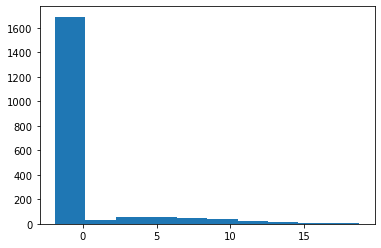

In [159]:
plt.hist(est.reisz_models_[0].predict(X))
plt.show()

In [160]:
print(est.reisz_models_[0].scores_)

[5929.062983542529, 13148.093262485821, 1015.8691957106873, 424.7404779759171, 25.132943419432443, 0.665262465834437, -2.3096214782437106e-05, 11783.0454577003, 46169.959596986155, 65120.70669147864, 68814.37576636716, 69008.78683626204, 69012.64075743068, 69012.69855578215]


In [161]:
print(est.reisz_models_[0].regl_)

3.455107294592218e-05


In [162]:
kest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_kernel_fn, n_splits=1)
kest.fit(X, y)
print([i * y_scale for i in kest.avg_moment()])
print([i * y_scale for i in kest.avg_moment(tmle=True)])

[3548.123161623499, 951.165144356365, 1682.7270691090164, 5413.519254137981]
[3550.469466009094, 951.1953484612412, 1685.0141381246567, 5415.924793893531]


In [163]:
print(kest.reisz_models_[0].scores_)

[-8.582181791610026, -8.568752077816722, -7.30161598870282, -9.29849183453675, -10.103027078375462, -9.653674389523664, -8.677850092762311, -8.231716556434703, -5.880250316306816, -1.8279555844612512, -0.30344520976230405, -0.03932795563909257]


In [164]:
print(kest.reisz_models_[0].regl_)

4.328761281083062e-05


In [165]:
from utilities import PluginRR

rfest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_rf_plugin_fn, n_splits=1)
rfest.fit(X, y)
print([i * y_scale for i in rfest.avg_moment()])
print([i * y_scale for i in rfest.avg_moment(tmle=True)])

[3716.3684185039983, 616.0653245261583, 2508.1598798254627, 4924.576957182534]
[4226.297544979248, 616.2127978850544, 3017.7997860437813, 5434.795303914715]


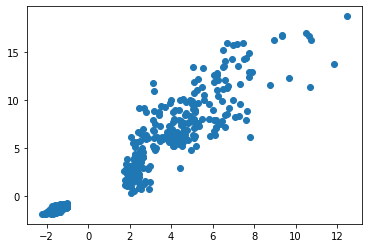

In [166]:
plt.scatter(rfest.reisz_models_[0].predict(X), est.reisz_models_[0].predict(X))
plt.show()

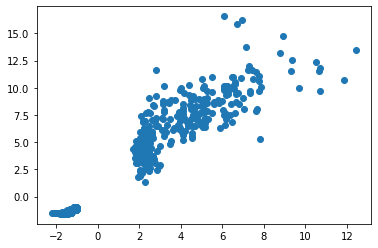

In [167]:
plt.scatter(rfest.reisz_models_[0].predict(X), kest.reisz_models_[0].predict(X))
plt.show()

In [16]:
from utilities import PluginRR

nnest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                       get_reisz_fn=get_agmm_fn, n_splits=1)
nnest.fit(X, y)
print([i * y_scale for i in nnest.avg_moment()])
print([i * y_scale for i in nnest.avg_moment(tmle=True)])

Splitting
Epoch #0
Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39
Epoch #40
Epoch #41
Epoch #42
Epoch #43
Epoch #44
Epoch #45
Epoch #46
Epoch #47
Epoch #48
Epoch #49
Epoch #50
Epoch #51
Epoch #52
Epoch #53
Epoch #54
Epoch #55
Epoch #56
Epoch #57
Epoch #58
Epoch #59
Epoch #60
Epoch #61
Epoch #62
Epoch #63
Epoch #64
Epoch #65
Epoch #66
Epoch #67
Epoch #68
Epoch #69
Epoch #70
Epoch #71
Epoch #72
Epoch #73
Epoch #74
Epoch #75
Epoch #76
Epoch #77
Epoch #78
Epoch #79
Epoch #80
Epoch #81
Epoch #82
Epoch #83
Epoch #84
Epoch #85
Epoch #86
Epoch #87
Epoch #88
Epoch #89
Epoch #90
Epoch #91
Epoch #92
Epoch #93
Epoch #94
Epoch #95
Epoch #96
Epoch #97
Epoch #98
Epoch #99


Validation moment violation: 0.12551098
Epoch #125
Validation moment violation: 0.099698626
Epoch #126
Validation moment violation: 0.08942034
Epoch #127
Validation moment violation: 0.06535544
Epoch #128
Validation moment violation: 0.04728854
Epoch #129
Validation moment violation: 0.028807156
Epoch #130
Validation moment violation: 0.024270833
Epoch #131
Validation moment violation: 0.025504481
Epoch #132
Validation moment violation: 0.026067453
Epoch #133
Validation moment violation: 0.025599942
Epoch #134
Validation moment violation: 0.027361225
Epoch #135
Validation moment violation: 0.026907021
Epoch #136
Validation moment violation: 0.026312867
Epoch #137
Validation moment violation: 0.026986912
Epoch #138
Validation moment violation: 0.026854992
Epoch #139
Validation moment violation: 0.027997399
Epoch #140
Validation moment violation: 0.039040014
Epoch #141
Validation moment violation: 0.048212502
Epoch #142
Validation moment violation: 0.049349952
Epoch #143
Validation momen

Validation moment violation: 0.017532049
Epoch #284
Validation moment violation: 0.016241653
Epoch #285
Validation moment violation: 0.013189494
Epoch #286
Validation moment violation: 0.01138599
Epoch #287
Validation moment violation: 0.01032397
Epoch #288
Validation moment violation: 0.010868609
Epoch #289
Validation moment violation: 0.011960357
Epoch #290
Validation moment violation: 0.012280311
Epoch #291
Validation moment violation: 0.021372776
Epoch #292
Validation moment violation: 0.016736489
Epoch #293
Validation moment violation: 0.028192602
Epoch #294
Validation moment violation: 0.031881515
Epoch #295
Validation moment violation: 0.025060482
Epoch #296
Validation moment violation: 0.028359238
Epoch #297
Validation moment violation: 0.014785212
Epoch #298
Validation moment violation: 0.011926315
Epoch #299
Validation moment violation: 0.011573378
Epoch #300
Validation moment violation: 0.011033472
Epoch #301
Validation moment violation: 0.021411832
Epoch #302
Validation mom

In [18]:
from utilities import PluginRR

rfest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_rf_plugin_fn, n_splits=1)
rfest.fit(X, y)
print([i * y_scale for i in rfest.avg_moment()])
print([i * y_scale for i in rfest.avg_moment(tmle=True)])

[18433.615497287286, 4625.212081286994, 9362.787690768644, 27504.44330380593]
[18514.11083576608, 4624.933717372328, 9443.828948243825, 27584.39272328834]


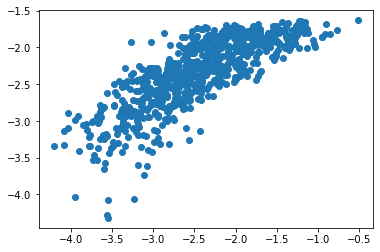

In [22]:
plt.scatter(rfest.reisz_models_[0].predict(X), nnest.reisz_models_[0].predict(X))
plt.show()